# Day 4 - Introduction to Deep Learning with PyTorch and MNIST

Today we build a complete, but compact, deep learning pipeline in Python using **PyTorch**:

- We treat deep learning as *curve fitting with very flexible functions*.
- We learn what **tensors** are and how **autograd** computes gradients.
- We load the **MNIST** digit dataset and visualize some samples.
- We define a small neural network in PyTorch and understand its math.
- We train it with a loss function and optimizer, track metrics, and visualize training.
- We save and reload the model and run simple inference.
- At the end, we run a small *experiment* to compare two training settings.

Useful library links (official docs):

- PyTorch: https://pytorch.org
- PyTorch documentation: https://docs.pytorch.org/
- torchvision (datasets and transforms): https://pytorch.org/vision/stable/
- NumPy: https://numpy.org
- Matplotlib: https://matplotlib.org

You should already be comfortable with:

- Basic Python syntax, functions, and control flow.
- Lists, dicts, list comprehensions.
- NumPy arrays, pandas DataFrames, and matplotlib plots.
- The ideas of variables, types, and modules.

We will now connect these to deep learning and neural networks.


## Daily agenda and time blocks

**09:00 - 10:30 (1h 30m)**  
- Deep learning as supervised learning and curve fitting  
- Simple loss functions and gradient based optimization  
- PyTorch tensors and automatic differentiation (autograd)

**10:30 - 10:45 (15m)**  
- Short break

**10:45 - 12:00 (1h 15m)**  
- MNIST dataset and DataLoader  
- Visualizing MNIST examples with matplotlib  
- Defining a simple neural network (`SimpleMNIST`) and its math

**12:00 - 13:00 (1h)**  
- Lunch break

**13:00 - 14:45 (1h 45m)**  
- Loss function and optimizer for classification  
- Full training loop for MNIST and evaluation  
- Tracking loss and accuracy and plotting curves

**14:45 - 15:00 (15m)**  
- Short break

**15:00 - 16:30 (1h 30m)**  
- Saving and loading models  
- Simple inference on test images  
- Complex example: running a small MNIST experiment with two configurations  
- Day 4 summary and discussion

We will explicitly mark good moments for breaks and questions. Try to keep roughly in sync with these blocks so everyone reaches the complex example at the end of the day.


## 1. Deep learning as supervised learning and curve fitting

At a high level, *supervised learning* means:

- We have input data $x$ (for example, a $28 \times 28$ pixel image of a digit).
- We have a known target $y$ (for example, the digit label $0,\dots,9$).
- We choose a **model** $f_\theta(x)$ with parameters $\theta$ (weights and biases).
- We choose a **loss function** $L(f_\theta(x), y)$ that is small when predictions are good.
- We adjust $\theta$ to minimize the *average loss* over all training examples.

Mathematically, for a dataset of $N$ examples $(x_i, y_i)$:

- The model is a function

$$
f_\theta : x \mapsto \hat{y}
$$

- The loss on a single example is $L(f_\theta(x_i), y_i)$.
- The training objective (average loss over the dataset) is

$$
J(\theta) = \frac{1}{N} \sum_{i=1}^{N} L\bigl(f_\theta(x_i), y_i\bigr).
$$

This is conceptually similar to **curve fitting** in physics or experimental work:

- You measure data points $(x_i, y_i)$.
- You choose a family of functions with parameters (for example, a line with slope and intercept).
- You choose a criterion (for example, least squares error).
- You adjust the parameters to minimize that criterion.

Deep learning uses very flexible functions (neural networks) and optimizes them with gradient-based algorithms. MNIST classification is “just” fitting a complicated non-linear function from images to digit labels.


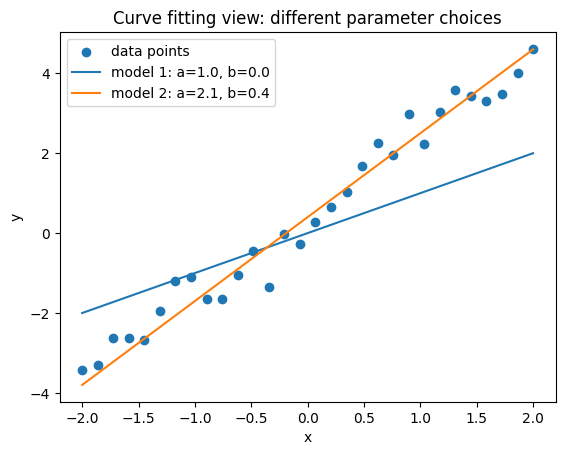

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# A tiny curve-fitting style example (not yet using PyTorch)
rng = np.random.default_rng(0)

# Synthetic data: y = 2x + 0.5 with some noise
x = np.linspace(-2, 2, 30)
true_y = 2 * x + 0.5
noise = rng.normal(scale=0.5, size=x.shape)
y = true_y + noise

# Two different "models" (lines) with different parameters
def line(a, b, x):
    return a * x + b

a1, b1 = 1.0, 0.0   # bad guess
a2, b2 = 2.1, 0.4   # better guess

plt.figure()
plt.scatter(x, y, label="data points")
plt.plot(x, line(a1, b1, x), label="model 1: a=1.0, b=0.0")
plt.plot(x, line(a2, b2, x), label="model 2: a=2.1, b=0.4")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Curve fitting view: different parameter choices")
plt.legend()
plt.show()

### ✏ Exercise (easy): Mean squared error for two lines

In the plot above we saw two candidate lines for the data. Now we will **quantify** which one fits better using **mean squared error (MSE)**.

For a set of predictions $y_{\text{pred},i}$ and targets $y_i$:

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \bigl(y_{\text{pred},i} - y_i\bigr)^2
$$

**Task:**

1. Using the same `x` and `y` arrays from the previous cell, compute:  
   - `mse1` for line parameters `(a1, b1)`  
   - `mse2` for line parameters `(a2, b2)`
2. Print both values.
3. Print which model has the smaller MSE.

You only need basic NumPy operations and the `line` function defined above.

In [ ]:
# TODO: Compute MSE for the two lines and compare them.

# Hints:
# - Use the existing x, y, line, a1, b1, a2, b2 from the previous cell.
# - Compute predictions y_pred1 and y_pred2.
# - Then compute mse1 and mse2 using the MSE formula.

# y_pred1 = ...
# y_pred2 = ...
# mse1 = ...
# mse2 = ...
# print("MSE for model 1:", mse1)
# print("MSE for model 2:", mse2)
# if mse1 < mse2:
#     print("Model 1 is better on this data.")
# else:
#     print("Model 2 is better on this data.")

In [6]:
# Reference solution for the MSE exercise
y_pred1 = line(a1, b1, x)
y_pred2 = line(a2, b2, x)

mse1 = np.mean((y_pred1 - y) ** 2)
mse2 = np.mean((y_pred2 - y) ** 2)

print("MSE for model 1:", mse1)
print("MSE for model 2:", mse2)
if mse1 < mse2:
    print("Model 1 is better on this data.")
else:
    print("Model 2 is better on this data.")

MSE for model 1: 1.747691163784833
MSE for model 2: 0.18291233837641963
Model 2 is better on this data.


### 💪 Exercise (advanced): A simple grid search for the best slope

Assume we fix the intercept at `b = 0.5` and only vary the slope `a` in the line

\[
y_{\text{pred}} = a x + 0.5.
\]

**Task:**

1. Create a NumPy array of candidate slopes, for example `a_values = np.linspace(0.0, 4.0, 41)` (step 0.1).
2. For each candidate slope `a`:
   - Compute predictions `y_pred = a * x + 0.5`.
   - Compute the mean squared error between `y_pred` and `y`.
3. Find the `a` with the **smallest MSE**.
4. Print the best `a` and its MSE.
5. Optionally, plot the data and the best-fit line.

This is a very simple version of numerical optimization by brute force search.


In [ ]:
# TODO: Implement a simple grid search over slopes a.

# a_values = np.linspace(...)
# best_a = None
# best_mse = None
# for a in a_values:
#     y_pred = ...
#     mse = ...
#     if best_mse is None or mse < best_mse:
#         best_mse = mse
#         best_a = a
#
# print("Best a:", best_a)
# print("Best MSE:", best_mse)
#
# Optional: plot best line
# plt.figure()
# plt.scatter(x, y, label="data")
# plt.plot(x, best_a * x + 0.5, label=f"best a={best_a:.2f}")
# plt.legend()
# plt.show()

Best a: 2.0
Best MSE: 0.1673843822939065


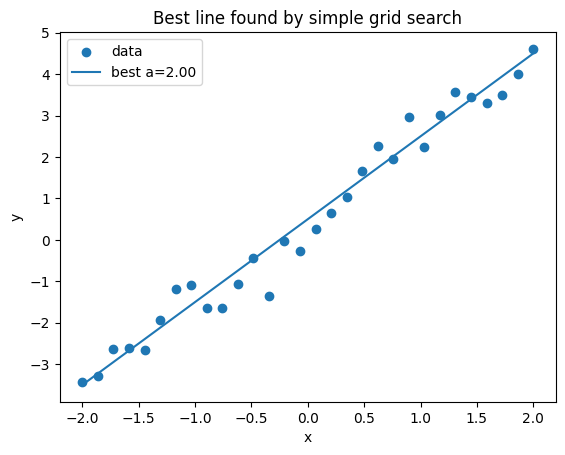

In [3]:
# Reference solution for the grid search exercise
a_values = np.linspace(0.0, 4.0, 41)
best_a = None
best_mse = None

for a in a_values:
    y_pred = a * x + 0.5
    mse = np.mean((y_pred - y) ** 2)
    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_a = a

print("Best a:", best_a)
print("Best MSE:", best_mse)

plt.figure()
plt.scatter(x, y, label="data")
plt.plot(x, best_a * x + 0.5, label=f"best a={best_a:.2f}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Best line found by simple grid search")
plt.show()

## 2. PyTorch tensors and automatic differentiation

So far we used NumPy. For deep learning we will use **PyTorch** tensors, which are similar but have two key extra features:

1. Tensors can live on **CPU or GPU**.
2. Tensors can be part of a **computation graph** and remember how they were computed. PyTorch can then automatically compute gradients.

A tensor is a generalization of:

- Scalar (0D tensor)
- Vector (1D tensor)
- Matrix (2D tensor)
- Higher dimensional arrays (3D, 4D, ...)

Each tensor has:

- A **shape** (for example `(64, 784)` for a batch of 64 flattened MNIST images).
- A **dtype** (for example `torch.float32`).
- A **device** (for this course we use CPU).

Autograd idea:

- If a tensor has `requires_grad=True`, PyTorch tracks all operations on it.
- When you call `.backward()` on a scalar result (for example a loss), PyTorch runs **reverse mode automatic differentiation** and fills the `.grad` field of all leaf tensors that require gradients.


In [4]:
import torch

# Create some tensors
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([[1.0, 2.0, 3.0],
                  [4.0, 5.0, 6.0]])

print("a:", a)
print("a shape:", a.shape)
print("b:", b)
print("b shape:", b.shape)

# Basic operations
c = a * 2.0
d = b + 10.0
print("c = a * 2:", c)
print("d = b + 10:", d)

# Conversion between NumPy and torch
np_array = np.array([[1.0, 2.0], [3.0, 4.0]])
t_from_np = torch.from_numpy(np_array)
back_to_np = t_from_np.numpy()

print("From NumPy:", t_from_np)
print("Back to NumPy:", back_to_np)

a: tensor([1., 2., 3.])
a shape: torch.Size([3])
b: tensor([[1., 2., 3.],
        [4., 5., 6.]])
b shape: torch.Size([2, 3])
c = a * 2: tensor([2., 4., 6.])
d = b + 10: tensor([[11., 12., 13.],
        [14., 15., 16.]])
From NumPy: tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)
Back to NumPy: [[1. 2.]
 [3. 4.]]


### ✏ Exercise (easy): Tensor statistics

**Task:**

1. Create a 2D tensor `data` of shape `(5, 3)` with some values of your choice (for example using `torch.randn`).
2. Compute:
   - The mean of each column (result shape `(3,)`).
   - The standard deviation of each column (also shape `(3,)`).
3. Print the results.

Hints:

- Use `data.mean(dim=0)` for the mean along rows.
- Use `data.std(dim=0)` for the standard deviation along rows.


In [ ]:
# TODO: Create a (5, 3) tensor and compute column-wise mean and std.

# data = torch.randn(5, 3)
# col_means = ...
# col_stds = ...
# print("Data:\n", data)
# print("Column means:", col_means)
# print("Column stds:", col_stds)

In [5]:
# Reference solution for tensor statistics
data = torch.randn(5, 3)
col_means = data.mean(dim=0)
col_stds = data.std(dim=0)

print("Data:\n", data)
print("Column means:", col_means)
print("Column stds:", col_stds)

Data:
 tensor([[-1.6335,  1.1480, -1.1746],
        [-1.1167,  0.3933, -0.2767],
        [-0.0351,  0.1272,  2.0483],
        [ 0.2526,  0.2138,  0.0244],
        [ 0.6962,  0.9906, -0.0916]])
Column means: tensor([-0.3673,  0.5746,  0.1060])
Column stds: tensor([0.9735, 0.4650, 1.1837])


### 💪 Exercise (advanced): Standardizing a batch

Standardizing features is common in data processing: subtract the mean and divide by the standard deviation.

**Task:**

1. Create a tensor `batch` of shape `(64, 10)` representing 64 samples with 10 features each (for example with `torch.randn`).
2. Compute the mean and standard deviation per feature (dimension 0).
3. Create a new tensor `batch_standardized` where each feature has zero mean and unit variance across the batch:

$$
x_{\text{standardized}} = \frac{x - \mu}{\sigma + \epsilon}
$$

where `\(\epsilon\)` is a small number like `1e-8` to avoid division by zero.

4. Verify by recomputing mean and std on `batch_standardized` along dimension 0 and printing them.

You only need tensor operations, no loops.


In [ ]:
# TODO: Standardize a batch of features.

# batch = torch.randn(64, 10)
# mean = ...
# std = ...
# eps = 1e-8
# batch_standardized = ...
#
# print("Means after standardization:", batch_standardized.mean(dim=0))
# print("Stds after standardization:", batch_standardized.std(dim=0))

In [7]:
# Reference solution for standardizing a batch
batch = torch.randn(64, 10)
mean = batch.mean(dim=0, keepdim=True)
std = batch.std(dim=0, keepdim=True)
eps = 1e-8

batch_standardized = (batch - mean) / (std + eps)

print("Means after standardization:", batch_standardized.mean(dim=0))
print("Stds after standardization:", batch_standardized.std(dim=0))

Means after standardization: tensor([ 2.6077e-08,  1.8626e-08, -2.2352e-08, -7.4506e-09, -7.4506e-09,
         3.7253e-09, -6.9849e-09,  3.7253e-08,  1.3039e-08, -9.3132e-10])
Stds after standardization: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


### 2.1 Autograd: gradients of a simple function

Let us create a scalar-valued function of a tensor and ask PyTorch for its gradient.

Example function:

$$
y = \operatorname{mean}\bigl((2x + 1)^2\bigr)
$$

where `x` is a tensor. PyTorch will compute the gradient $\frac{dy}{dx}$.


In [8]:
# Autograd example
x = torch.linspace(-2.0, 2.0, steps=5, requires_grad=True)
y = torch.mean((2 * x + 1) ** 2)  # scalar
print("x:", x)
print("y:", y)

y.backward()  # compute gradients
print("dy/dx:", x.grad)

x: tensor([-2., -1.,  0.,  1.,  2.], requires_grad=True)
y: tensor(9., grad_fn=<MeanBackward0>)
dy/dx: tensor([-2.4000, -0.8000,  0.8000,  2.4000,  4.0000])


The `.grad` field of `x` now stores the derivative of `y` with respect to each element of `x`. This is the basic building block PyTorch uses to optimize neural networks.

### ✏ Exercise (easy): Gradient of a quadratic function

Consider the function

$$
y = \sum_i (w x_i)^2
$$

for a scalar parameter `w` and fixed data $x_i$.

**Task:**

1. Create a tensor `w` with `requires_grad=True` and initial value `w = 1.0`.  
2. Create a fixed data tensor `x` of shape `(5,)`, for example `torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])`.  
3. Compute `y = torch.sum((w * x) ** 2)`.  
4. Call `y.backward()` and print `w.grad`.  
5. Then set `w.grad = None`, change the value of `w.data` to something else (for example `0.5`), recompute `y` and `y.backward()`, and print the new gradient.

This illustrates how the gradient depends on both the parameter and the data.


In [ ]:
# TODO: Implement the gradient computation for the quadratic function.

# w = torch.tensor(1.0, requires_grad=True)
# x = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
# y = ...
# y.backward()
# print("Gradient at w=1.0:", w.grad)

# w.grad = None
# with torch.no_grad():
#     w.data = torch.tensor(0.5)
# y = ...
# y.backward()
# print("Gradient at w=0.5:", w.grad)

In [9]:
# Reference solution for the quadratic gradient exercise
w = torch.tensor(1.0, requires_grad=True)
x = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
y = torch.sum((w * x) ** 2)
y.backward()
print("Gradient at w=1.0:", w.grad)

w.grad = None
with torch.no_grad():
    w.data = torch.tensor(0.5)
y = torch.sum((w * x) ** 2)
y.backward()
print("Gradient at w=0.5:", w.grad)

Gradient at w=1.0: tensor(110.)
Gradient at w=0.5: tensor(55.)


### 💪 Exercise (advanced): Visualizing a ReLU activation function

In neural networks we often use the ReLU activation function

$$
\mathrm{ReLU}(z) = \max(0, z).
$$

**Task:**

1. Use PyTorch to create a 1D tensor `z` from `-3` to `3` (for example `torch.linspace(-3, 3, steps=100)`).  
2. Compute `relu_z = torch.relu(z)`.  
3. Use matplotlib to plot both `z` and `relu_z` as a line plot.  
4. Label the axes and set the title to `"ReLU activation function"`.

This gives a visual intuition for the nonlinearity used in the MNIST network.


In [10]:
# TODO: Plot the ReLU activation function using PyTorch and matplotlib.

# z = torch.linspace(-3.0, 3.0, steps=100)
# relu_z = torch.relu(z)

# plt.figure()
# plt.plot(z.numpy(), relu_z.numpy())
# plt.xlabel("z")
# plt.ylabel("ReLU(z)")
# plt.title("ReLU activation function")
# plt.grid(True)
# plt.show()

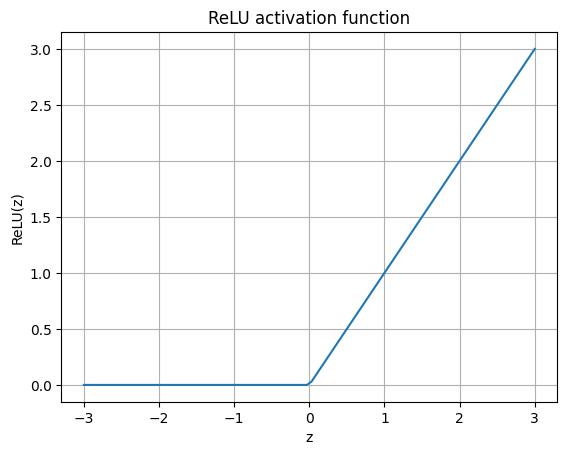

In [11]:
# Reference solution for plotting ReLU
z = torch.linspace(-3.0, 3.0, steps=100)
relu_z = torch.relu(z)

plt.figure()
plt.plot(z.numpy(), relu_z.numpy())
plt.xlabel("z")
plt.ylabel("ReLU(z)")
plt.title("ReLU activation function")
plt.grid(True)
plt.show()

---
# Short break (10:30 - 10:45)

Stand up, drink water, stretch a bit.

---

## 3. MNIST dataset and DataLoader

Now we move to real image data. We use the **MNIST** dataset:

- 60 000 training images and 10 000 test images.
- Each image is 28x28 pixels, grayscale.
- Each image has a label 0..9 (the digit).

PyTorch provides MNIST through the **torchvision** package:

- `torchvision.datasets.MNIST` downloads and stores the data.
- `torchvision.transforms.ToTensor()` converts PIL images to tensors with values in `[0, 1]`.

We then wrap the dataset in a `DataLoader` to get **mini-batches**:

- Each batch is a tensor of shape `(batch_size, 1, 28, 28)` for images.
- Labels are a tensor of shape `(batch_size,)`.
- Batching lets us use vectorized computation for better performance.


In [12]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# 1) Device: for this course we force CPU
device = torch.device("cpu")
print("Using device:", device)

# 2) MNIST dataset and DataLoaders
transform = transforms.ToTensor()

train_ds = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True,
)

test_ds = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True,
)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

print("Number of training samples:", len(train_ds))
print("Number of test samples:", len(test_ds))

Using device: cpu


100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:02<00:00, 3.73MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 261kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 1.92MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 6.80MB/s]

Number of training samples: 60000
Number of test samples: 10000


### Visualizing some MNIST digits with matplotlib

Let us inspect a few examples to build intuition about the data.


Batch shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


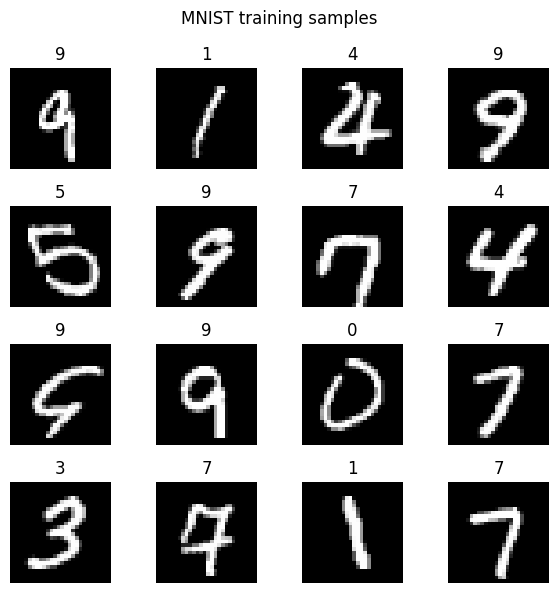

In [13]:
# Show a grid of MNIST images
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)

# images: (batch_size, 1, 28, 28)
batch_size = images.shape[0]

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i, 0].numpy(), cmap="gray")
    plt.title(str(labels[i].item()))
    plt.axis("off")
plt.suptitle("MNIST training samples")
plt.tight_layout()
plt.show()

### ✏ Exercise (easy): Inspect pixel statistics

Each MNIST image is a 28x28 grid of pixel intensities in `[0, 1]`.

**Task:**

1. Take one batch from `train_loader` (similar to the cell above).
2. Compute:
   - The minimum and maximum pixel value in the batch.
   - The mean pixel value in the batch.
3. Print these statistics.

You can use tensor operations like `.min()`, `.max()`, and `.mean()`.


In [ ]:
# TODO: Compute basic pixel statistics for one batch.

# images, labels = next(iter(train_loader))
# batch_min = ...
# batch_max = ...
# batch_mean = ...
# print("Batch min:", batch_min.item())
# print("Batch max:", batch_max.item())
# print("Batch mean:", batch_mean.item())

In [14]:
# Reference solution for pixel statistics
images, labels = next(iter(train_loader))
batch_min = images.min()
batch_max = images.max()
batch_mean = images.mean()

print("Batch min:", batch_min.item())
print("Batch max:", batch_max.item())
print("Batch mean:", batch_mean.item())

Batch min: 0.0
Batch max: 1.0
Batch mean: 0.12774969637393951


### 💪 Exercise (advanced): Compute dataset mean and std (approximate)

In many image pipelines we normalize pixels by subtracting the mean and dividing by the standard deviation of the dataset.

**Task:**

1. Iterate over `train_loader` for a few batches (for example 100 batches).
2. For each batch, compute the mean and squared mean of the pixel values.
3. Use these to estimate the overall mean and standard deviation using the formulas:

   - Mean: average of batch means weighted by batch size.
   - Variance estimate: `E[x^2] - (E[x])^2` where `E[x^2]` is the average squared value.

4. Print the approximate mean and std.

Hint: Keep running sums `sum_pixels` and `sum_pixels_sq` and total count `n_pixels`.


In [ ]:
# TODO: Approximate MNIST mean and std from a subset of training batches.

# max_batches = 100
# sum_pixels = 0.0
# sum_pixels_sq = 0.0
# n_pixels = 0
#
# for batch_idx, (images, labels) in enumerate(train_loader):
#     if batch_idx >= max_batches:
#         break
#     # images shape: (batch_size, 1, 28, 28)
#     batch = images.view(images.size(0), -1)  # flatten per image
#     sum_pixels += batch.sum().item()
#     sum_pixels_sq += (batch ** 2).sum().item()
#     n_pixels += batch.numel()
#
# mean = sum_pixels / n_pixels
# mean_sq = sum_pixels_sq / n_pixels
# var = mean_sq - mean ** 2
# std = var ** 0.5
#
# print("Approximate MNIST mean:", mean)
# print("Approximate MNIST std:", std)

In [15]:
# Reference solution for approximate MNIST mean and std
max_batches = 100
sum_pixels = 0.0
sum_pixels_sq = 0.0
n_pixels = 0

for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx >= max_batches:
        break
    batch = images.view(images.size(0), -1)
    sum_pixels += batch.sum().item()
    sum_pixels_sq += (batch ** 2).sum().item()
    n_pixels += batch.numel()

mean = sum_pixels / n_pixels
mean_sq = sum_pixels_sq / n_pixels
var = mean_sq - mean ** 2
std = var ** 0.5

print("Approximate MNIST mean:", mean)
print("Approximate MNIST std:", std)

Approximate MNIST mean: 0.13142755780901227
Approximate MNIST std: 0.3089533375593598


## 4. SimpleMNIST network and the math of what we optimize

We now define a small feedforward neural network for MNIST.

Architecture:

1. Input: image of shape `(1, 28, 28)` which we flatten to a vector of size 784.  
2. Hidden layer: fully connected `Linear(784, 128)` followed by ReLU.  
3. Output layer: `Linear(128, 10)` that produces **logits** (one raw score per class 0..9).

In PyTorch code:

```python
class SimpleMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),        # (1, 28, 28) -> (784,)
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.net(x)
````

### 4.1 Mathematical form

Let:

* $x$ be a flattened input image in $\mathbb{R}^{784}$.
* $W_1 \in \mathbb{R}^{128 \times 784}$, $b_1 \in \mathbb{R}^{128}$.
* $W_2 \in \mathbb{R}^{10 \times 128}$,  $b_2 \in \mathbb{R}^{10}$.
* $\sigma(z)$ be the ReLU activation applied elementwise: $\sigma(z) = \max(0, z)$.

The network computes:

1. Hidden pre-activation:

$$
z_1 = W_1 x + b_1
$$

2. Hidden activation:

$$
h = \sigma(z_1)
$$

3. Output logits:

$$
z_2 = W_2 h + b_2
$$

The vector $z_2$ has 10 components (one per digit).

To turn logits into probabilities, we use the **softmax**:

$$
p_k = \frac{\exp(z_{2,k})}{\sum_{j=1}^{10} \exp(z_{2,j})}
$$

### 4.2 Loss function for classification

For a single example with true class index $y \in {0,\ldots,9}$ and predicted probabilities $p_k$, the **cross-entropy loss** is:

$$
L(\theta; x, y) = -\log p_y.
$$

For a batch of $N$ examples, the loss is the average:

$$
J(\theta) = \frac{1}{N} \sum_{i=1}^N L(\theta; x_i, y_i).
$$

PyTorch provides `nn.CrossEntropyLoss`, which internally combines:

* `nn.LogSoftmax` applied to the logits, and
* Negative log-likelihood loss.

Our training objective on MNIST is to **find parameters $(W_1, b_1, W_2, b_2)$ that minimize this average cross-entropy loss over the training set**.

In [16]:
# SimpleMNIST model definition
class SimpleMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),      # 1x28x28 -> 784
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.net(x)


model = SimpleMNIST().to(device)
print(model)

# Test on a dummy batch
images, labels = next(iter(train_loader))
images = images.to(device)

logits = model(images)
print("Input shape:", images.shape)
print("Logits shape:", logits.shape)  # (batch_size, 10)


SimpleMNIST(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)
Input shape: torch.Size([64, 1, 28, 28])
Logits shape: torch.Size([64, 10])


### ✏ Exercise (easy): Count the number of parameters

**Task:**

1. Using the `model` defined above, compute the **total number of parameters**.
2. Also compute the number of parameters in each `Linear` layer separately.
3. Print the results.

Hints:

* You can iterate over `model.parameters()` and sum `p.numel()`.
* For per-layer counts, you can access `model.net[1]` and `model.net[3]`, which are the two `Linear` layers.
* Remember that a linear layer with shape `(out_features, in_features)` has `out_features * in_features` weights plus `out_features` biases.
  

In [ ]:
# TODO: Compute and print total and per-layer parameter counts.

# total_params = sum(p.numel() for p in model.parameters())

# print("Total parameters:", total_params)

#

# layer1 = model.net[1]

# layer2 = model.net[3]

# params_layer1 = ...

# params_layer2 = ...

# print("Layer 1 parameters:", params_layer1)

# print("Layer 2 parameters:", params_layer2)

In [17]:
# Reference solution for parameter counting
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

layer1 = model.net[1]
layer2 = model.net[3]
params_layer1 = layer1.weight.numel() + layer1.bias.numel()
params_layer2 = layer2.weight.numel() + layer2.bias.numel()

print("Layer 1 parameters:", params_layer1)
print("Layer 2 parameters:", params_layer2)

Total parameters: 101770
Layer 1 parameters: 100480
Layer 2 parameters: 1290


### 💪 Exercise (advanced): Add a second hidden layer

Extend `SimpleMNIST` to have two hidden layers:

* Flatten -> Linear(784, 256) -> ReLU
* Linear(256, 128) -> ReLU
* Linear(128, 10)

**Task:**

1. Define a new class `DeeperMNIST` that implements this architecture.
2. Instantiate it and move it to `device`.
3. Pass one batch through it and print the output shape.
4. Compute and print the total number of parameters.

You can reuse the pattern from `SimpleMNIST`.


In [ ]:
# TODO: Implement DeeperMNIST with two hidden layers.

# class DeeperMNIST(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(784, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 10),
#         )
# 
#     def forward(self, x):
#         return self.net(x)
# 
# 
# # Instantiate and test the model
# deeper_model = DeeperMNIST().to(device)
# 
# images, labels = next(iter(train_loader))
# images = images.to(device)
# 
# logits = deeper_model(images)
# print("Output shape:", logits.shape)
# print("Total parameters:", sum(p.numel() for p in deeper_model.parameters()))


In [18]:
# Reference solution for DeeperMNIST
class DeeperMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.net(x)


deeper_model = DeeperMNIST().to(device)

images, labels = next(iter(train_loader))
images = images.to(device)

logits = deeper_model(images)
print("Output shape:", logits.shape)
print("Total parameters:", sum(p.numel() for p in deeper_model.parameters()))


Output shape: torch.Size([64, 10])
Total parameters: 235146


---

# Lunch break (12:00 - 13:00)

Time to rest your brain and get some food.

---

## 5. Loss function and optimizer

To train the network we need two components:

1. **Loss function** - measures how wrong the model is.

   * For multi-class classification we use `nn.CrossEntropyLoss`.
   * Input: raw logits of shape `(batch_size, num_classes)` and integer labels `(batch_size,)`.
   * It applies `LogSoftmax` internally and computes the negative log-likelihood.

2. **Optimizer** - updates parameters using gradients.

   * We use `torch.optim.Adam` here.
   * Typical steps in one update:

     1. `optimizer.zero_grad()` - clear old gradients.
     2. Compute predictions.
     3. Compute loss.
     4. `loss.backward()` - compute gradients.
     5. `optimizer.step()` - apply parameter update.

We will now implement a single training step on one batch to see all these pieces together.


In [19]:
# Recreate a fresh SimpleMNIST model for training
model = SimpleMNIST().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Take one batch

images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

# One manual training step

optimizer.zero_grad()
logits = model(images)
loss = criterion(logits, labels)
print("Loss on this batch:", loss.item())

loss.backward()
optimizer.step()

Loss on this batch: 2.2845335006713867


### ✏ Exercise (easy): Wrap a single training step into a function

**Task:**

1. Write a function `train_step(model, optimizer, criterion, images, labels, device)` that:

   * Moves `images` and `labels` to `device`.
   * Performs one training step:

     * `optimizer.zero_grad()`
     * forward pass
     * loss computation
     * backward
     * optimizer step
   * Returns the scalar loss as a Python float.

2. Test the function on one batch from `train_loader` and print the loss.

This is a small building block of the full training loop.


In [ ]:
# TODO: Implement train_step.

# def train_step(model, optimizer, criterion, images, labels, device):

# images = images.to(device)

# labels = labels.to(device)

# optimizer.zero_grad()

# logits = ...

# loss = ...

# loss.backward()

# optimizer.step()

# return loss.item()

#

# images, labels = next(iter(train_loader))

# batch_loss = train_step(model, optimizer, criterion, images, labels, device)

# print("Batch loss from train_step:", batch_loss)

In [ ]:
# Reference solution for train_step
def train_step(model, optimizer, criterion, images, labels, device):
images = images.to(device)
labels = labels.to(device)
optimizer.zero_grad()
logits = model(images)
loss = criterion(logits, labels)
loss.backward()
optimizer.step()
return loss.item()

images, labels = next(iter(train_loader))
batch_loss = train_step(model, optimizer, criterion, images, labels, device)
print("Batch loss from train_step:", batch_loss)

### 💪 Exercise (advanced): Track loss over several steps

**Task:**

1. Recreate a fresh `SimpleMNIST` model, loss, and optimizer.
2. Take 50 batches from `train_loader`.
3. For each batch, call `train_step` and collect the loss values in a Python list.
4. After the loop, use matplotlib to plot the loss values as a function of step index.
5. Label the axes and add a title `"Training loss over 50 steps"`.

This gives a first visual feeling for how loss tends to decrease as we train.


In [ ]:
# TODO: Track and plot loss over several steps.

# model = SimpleMNIST().to(device)

# criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=1e-3)

#

# losses = []

# for step, (images, labels) in enumerate(train_loader):

# if step >= 50:

# break

# loss_value = train_step(model, optimizer, criterion, images, labels, device)

# losses.append(loss_value)

#

# plt.figure()

# plt.plot(losses)

# plt.xlabel("Step")

# plt.ylabel("Loss")

# plt.title("Training loss over 50 steps")

# plt.grid(True)

# plt.show()

In [ ]:
# Reference solution for tracking loss
model = SimpleMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []
for step, (images, labels) in enumerate(train_loader):
if step >= 50:
break
loss_value = train_step(model, optimizer, criterion, images, labels, device)
losses.append(loss_value)

plt.figure()
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training loss over 50 steps")
plt.grid(True)
plt.show()

## 6. Full training loop and evaluation (MNIST example)

We now combine everything into a compact but complete training script.

Structure:

1. Set device.
2. Prepare datasets and DataLoaders.
3. Define `SimpleMNIST` model.
4. Define loss (`nn.CrossEntropyLoss`) and optimizer (`optim.Adam`).
5. Training loop over epochs:

   * For each batch, run training step and accumulate loss.
   * Print average loss per epoch.
6. Evaluation:

   * Set `model.eval()`.
   * Disable gradients with `torch.no_grad()`.
   * Compute accuracy on the test set.

This is the kind of script you will see often in PyTorch examples.


In [ ]:
# Full training loop (small number of epochs to keep it fast)

# 1) Device

device = torch.device("cpu")

# 2) Datasets and DataLoaders (already created above, but we recreate for clarity)

transform = transforms.ToTensor()

train_ds = torchvision.datasets.MNIST(
root="./data",
train=True,
transform=transform,
download=True,
)
test_ds = torchvision.datasets.MNIST(
root="./data",
train=False,
transform=transform,
download=True,
)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

# 3) Model

model = SimpleMNIST().to(device)

# 4) Loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 5) Training loop

num_epochs = 3
train_loss_history = []

for epoch in range(num_epochs):
model.train()
total_loss = 0.0

```
for x_batch, y_batch in train_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    optimizer.zero_grad()
    preds = model(x_batch)
    loss = criterion(preds, y_batch)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

avg_loss = total_loss / len(train_loader)
train_loss_history.append(avg_loss)
print(f"Epoch {epoch + 1} | Loss: {avg_loss:.4f}")
```

# 6) Evaluation

model.eval()
correct = 0
total = 0

with torch.no_grad():
for x_batch, y_batch in test_loader:
x_batch, y_batch = x_batch.to(device), y_batch.to(device)
preds = model(x_batch)
_, predicted = torch.max(preds, 1)
total += y_batch.size(0)
correct += (predicted == y_batch).sum().item()

accuracy = 100.0 * correct / total
print(f"Test accuracy: {accuracy:.2f}%")

### ✏ Exercise (easy): Plot training loss over epochs

During the training loop above we collected `train_loss_history`.

**Task:**

1. Use matplotlib to plot `train_loss_history` as a function of epoch index.
2. Label the x-axis (`"Epoch"`) and y-axis (`"Average training loss"`).
3. Add a title `"Training loss per epoch"`.

This gives a quick visual summary of how training progressed.


In [ ]:
# TODO: Plot training loss per epoch from train_loss_history.

# epochs = range(1, len(train_loss_history) + 1)

# plt.figure()

# plt.plot(epochs, train_loss_history, marker="o")

# plt.xlabel("Epoch")

# plt.ylabel("Average training loss")

# plt.title("Training loss per epoch")

# plt.grid(True)

# plt.show()

In [ ]:
# Reference solution for plotting training loss per epoch
epochs = range(1, len(train_loss_history) + 1)
plt.figure()
plt.plot(epochs, train_loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average training loss")
plt.title("Training loss per epoch")
plt.grid(True)
plt.show()

### 💪 Exercise (advanced): Add accuracy evaluation per epoch

Extend the training loop so that after each epoch you also compute the accuracy on the **test set** and store it in a list `test_acc_history`.

**Task:**

1. After each epoch:

   * Set `model.eval()`.
   * Loop over `test_loader` with `torch.no_grad()`.
   * Compute accuracy (percentage of correct predictions).
   * Append to `test_acc_history`.
   * Then set `model.train()` again for the next epoch.
2. After training, plot both:

   * Training loss per epoch.
   * Test accuracy per epoch.

You can put the two plots side by side or one after another.


In [ ]:
# TODO: Add per-epoch test accuracy and plot.

# test_acc_history = []

#

# for epoch in range(num_epochs):

# ...

# # training loop as before

# ...

#

# # compute test accuracy here

# # model.eval()

# # with torch.no_grad():

# #     ...

# # test_acc_history.append(acc)

# # model.train()

#

# # After training, plot both curves

# # epochs = range(1, num_epochs + 1)

# # plt.figure()

# # plt.plot(epochs, train_loss_history, marker="o")

# # plt.xlabel("Epoch")

# # plt.ylabel("Average training loss")

# # plt.title("Training loss per epoch")

# # plt.grid(True)

# # plt.show()

#

# # plt.figure()

# # plt.plot(epochs, test_acc_history, marker="o")

# # plt.xlabel("Epoch")

# # plt.ylabel("Test accuracy (%)")

# # plt.title("Test accuracy per epoch")

# # plt.grid(True)

# # plt.show()

In [ ]:
# Reference solution for per-epoch accuracy
num_epochs = 3
model = SimpleMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loss_history = []
test_acc_history = []

for epoch in range(num_epochs):
model.train()
total_loss = 0.0

```
for x_batch, y_batch in train_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    preds = model(x_batch)
    loss = criterion(preds, y_batch)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

avg_loss = total_loss / len(train_loader)
train_loss_history.append(avg_loss)

# Evaluation for this epoch
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        _, predicted = torch.max(preds, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
epoch_acc = 100.0 * correct / total
test_acc_history.append(epoch_acc)
print(f"Epoch {epoch + 1}: loss={avg_loss:.4f}, test acc={epoch_acc:.2f}%")
```

# Plots

epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average training loss")
plt.title("Training loss per epoch")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, test_acc_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test accuracy (%)")
plt.title("Test accuracy per epoch")
plt.grid(True)
plt.show()

---

# Short break (14:45 - 15:00)

Move away from the screen, stretch, and refocus.

---

## 7. Saving and loading models, and running inference

In real projects, you rarely train a model once and forget it. You usually want to:

* Save trained models to disk.
* Reload them later to run inference on new data.
* Possibly keep multiple versions (model A, model B, etc.).

PyTorch uses **state dicts**:

* `model.state_dict()` returns an `OrderedDict` mapping parameter names to tensors.
* `torch.save(model.state_dict(), path)` writes it to disk.
* To reload:

  1. Recreate the same model architecture.
  2. Load the state dict with `model.load_state_dict(torch.load(path))`.
     

In [ ]:
# Assume we have a trained model called "model" from the previous section
save_path = "simple_mnist_state_dict.pth"
torch.save(model.state_dict(), save_path)
print("Model state dict saved to:", save_path)

# Create a new model instance and load the weights

loaded_model = SimpleMNIST().to(device)
loaded_model.load_state_dict(torch.load(save_path, map_location=device))
loaded_model.eval()

# Check that predictions match on a small batch

images, labels = next(iter(test_loader))
images = images.to(device)
with torch.no_grad():
logits_original = model(images)
logits_loaded = loaded_model(images)

diff = torch.abs(logits_original - logits_loaded).max().item()
print("Max difference between original and loaded logits:", diff)

### ✏ Exercise (easy): Helper function to save a model

**Task:**

1. Implement a function `save_model_state(model, path)` that:

   * Takes a PyTorch model and a file path.
   * Saves `model.state_dict()` to the given path using `torch.save`.
2. Call the function to save `loaded_model` (or any model) to `"simple_mnist_saved_by_function.pth"`.

This prepares the pattern you will use in larger projects.


In [ ]:
# TODO: Implement save_model_state and use it.

# def save_model_state(model, path):

# ...

#

# save_model_state(loaded_model, "simple_mnist_saved_by_function.pth")

In [ ]:
# Reference solution for save_model_state
def save_model_state(model, path):
torch.save(model.state_dict(), path)

save_model_state(loaded_model, "simple_mnist_saved_by_function.pth")
print("Saved model via helper to simple_mnist_saved_by_function.pth")

### 7.1 Inference on new data and visualizing predictions

For inference we:

* Put the model in evaluation mode with `model.eval()`.
* Disable gradient tracking with `torch.no_grad()`.
* Preprocess the input to match training (shape and scaling).
* Run a forward pass and take the `argmax` of the logits to get the predicted class.
  

In [ ]:
# Show a few test images with predicted labels

loaded_model.eval()
images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
logits = loaded_model(images)
preds = torch.argmax(logits, dim=1)

plt.figure(figsize=(6, 6))
for i in range(16):
plt.subplot(4, 4, i + 1)
plt.imshow(images[i, 0].cpu().numpy(), cmap="gray")
true_label = labels[i].item()
pred_label = preds[i].item()
plt.title(f"T:{true_label} P:{pred_label}")
plt.axis("off")
plt.suptitle("MNIST test samples - true (T) vs predicted (P)")
plt.tight_layout()
plt.show()

### ✏ Exercise (easy): Predict a single digit

**Task:**

1. Write a function `predict_digit(model, image, device)` that:

   * Takes a model, a single image tensor of shape `(1, 28, 28)`, and a device.
   * Adds a batch dimension so the shape becomes `(1, 1, 28, 28)`.
   * Moves the tensor to device.
   * Runs the model in evaluation mode under `torch.no_grad()`.
   * Returns the predicted digit as an integer.

2. Test the function on one image from `test_loader` and print the predicted and true digit.
   

In [ ]:
# TODO: Implement predict_digit.

# def predict_digit(model, image, device):

# model.eval()

# with torch.no_grad():

# image = image.unsqueeze(0).to(device)  # (1, 1, 28, 28)

# logits = ...

# pred = ...

# return pred

#

# example_images, example_labels = next(iter(test_loader))

# img0 = example_images[0]

# true_label = example_labels[0].item()

# pred_label = predict_digit(loaded_model, img0, device)

# print(f"True: {true_label}, Predicted: {pred_label}")

In [ ]:
# Reference solution for predict_digit
def predict_digit(model, image, device):
model.eval()
with torch.no_grad():
image = image.unsqueeze(0).to(device)
logits = model(image)
pred = torch.argmax(logits, dim=1)
return int(pred.item())

example_images, example_labels = next(iter(test_loader))
img0 = example_images[0]
true_label = example_labels[0].item()
pred_label = predict_digit(loaded_model, img0, device)
print(f"True: {true_label}, Predicted: {pred_label}")

### 💪 Exercise (advanced): Show a grid of predictions with confidence

Extend the visualization:

**Task:**

1. Take a batch of test images.
2. For the first 16 images:

   * Compute predicted probabilities by applying `softmax` to the logits.
   * Extract the probability of the predicted class.
3. Plot a 4x4 grid similar to before, but set the title of each subplot to include:

   * True label.
   * Predicted label.
   * Confidence (probability of predicted class) as a percentage, for example `"T:3 P:5 (87%)"`.

You can use `torch.softmax(logits, dim=1)` and then `probs[range(batch_size), preds]` to pick the relevant probabilities.


In [ ]:
# TODO: Visualize predictions with confidence.

# loaded_model.eval()

# images, labels = next(iter(test_loader))

# images = images.to(device)

# with torch.no_grad():

# logits = loaded_model(images)

# probs = torch.softmax(logits, dim=1)

# preds = torch.argmax(probs, dim=1)

#

# plt.figure(figsize=(6, 6))

# for i in range(16):

# plt.subplot(4, 4, i + 1)

# plt.imshow(images[i, 0].cpu().numpy(), cmap="gray")

# true_label = labels[i].item()

# pred_label = preds[i].item()

# confidence = probs[i, pred_label].item() * 100.0

# plt.title(f"T:{true_label} P:{pred_label} ({confidence:.1f}%)")

# plt.axis("off")

# plt.suptitle("MNIST predictions with confidence")

# plt.tight_layout()

# plt.show()

In [ ]:
# Reference solution for predictions with confidence
loaded_model.eval()
images, labels = next(iter(test_loader))
images = images.to(device)
with torch.no_grad():
logits = loaded_model(images)
probs = torch.softmax(logits, dim=1)
preds = torch.argmax(probs, dim=1)

plt.figure(figsize=(6, 6))
for i in range(16):
plt.subplot(4, 4, i + 1)
plt.imshow(images[i, 0].cpu().numpy(), cmap="gray")
true_label = labels[i].item()
pred_label = preds[i].item()
confidence = probs[i, pred_label].item() * 100.0
plt.title(f"T:{true_label} P:{pred_label} ({confidence:.1f}%)")
plt.axis("off")
plt.suptitle("MNIST predictions with confidence")
plt.tight_layout()
plt.show()

## 8. Complex example: compare two training configurations on MNIST

As a final exercise, we build a tiny experiment framework to compare two configurations:

* Same `SimpleMNIST` architecture.
* Different learning rates and numbers of epochs.

We will:

1. Define a helper function `run_experiment(config)` that:

   * Creates a new model, optimizer, and loss.
   * Trains for `config["epochs"]` epochs.
   * Returns a summary dict with:

     * `"name"`: a short name for the experiment.
     * `"lr"`: learning rate.
     * `"epochs"`: number of epochs.
     * `"final_train_loss"` and `"final_test_acc"`.

2. Run two experiments:

   * `exp1`: learning rate 1e-3, 3 epochs.
   * `exp2`: learning rate 1e-4, 3 epochs.

3. Collect results in a list of dicts.

4. Use pandas and matplotlib to create a small bar plot of final test accuracies.

This exercise connects modeling, training loops, metrics, and visualization.


In [ ]:
import pandas as pd

### 🏃‍♂️ Complex exercise: implement `run_experiment` and compare results

**Task:**

1. Complete the `run_experiment(config)` function below.
2. Use the provided `configs` list to run two experiments.
3. Build a pandas DataFrame from the list of results.
4. Plot a bar chart of final test accuracy for each experiment.

Be careful to set the model to train or eval mode when appropriate, and to use `torch.no_grad()` during evaluation.


In [ ]:
# TODO: Implement run_experiment and compare two configurations.

def run_experiment(config, train_loader, test_loader, device):
"""
Run one training experiment on MNIST.

```
config: dict with keys:
    - "name": experiment name
    - "lr": learning rate
    - "epochs": number of epochs
Returns a dict with summary statistics.
"""
# 1) Create model, criterion, optimizer
model = SimpleMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

train_loss_history = []

for epoch in range(config["epochs"]):
    model.train()
    total_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_loss)

# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        _, predicted = torch.max(preds, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
final_test_acc = 100.0 * correct / total

return {
    "name": config["name"],
    "lr": config["lr"],
    "epochs": config["epochs"],
    "final_train_loss": train_loss_history[-1],
    "final_test_acc": final_test_acc,
}
```

# Example configurations

configs = [
{"name": "lr=1e-3", "lr": 1e-3, "epochs": 3},
{"name": "lr=1e-4", "lr": 1e-4, "epochs": 3},
]

results = []
for cfg in configs:
print(f"Running experiment: {cfg['name']}")
summary = run_experiment(cfg, train_loader, test_loader, device)
print("  final train loss:", summary["final_train_loss"])
print("  final test acc:", summary["final_test_acc"])
results.append(summary)

df_results = pd.DataFrame(results)
display(df_results)

# Plot final test accuracy comparison

plt.figure()
plt.bar(df_results["name"], df_results["final_test_acc"])
plt.ylabel("Final test accuracy (%)")
plt.title("Comparison of MNIST experiments")
plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()

In [ ]:
# Reference solution for the complex example
def run_experiment(config, train_loader, test_loader, device):
model = SimpleMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

```
train_loss_history = []

for epoch in range(config["epochs"]):
    model.train()
    total_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_loss)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        _, predicted = torch.max(preds, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
final_test_acc = 100.0 * correct / total

return {
    "name": config["name"],
    "lr": config["lr"],
    "epochs": config["epochs"],
    "final_train_loss": train_loss_history[-1],
    "final_test_acc": final_test_acc,
}
```

configs = [
{"name": "lr=1e-3", "lr": 1e-3, "epochs": 3},
{"name": "lr=1e-4", "lr": 1e-4, "epochs": 3},
]

results = []
for cfg in configs:
print(f"Running experiment: {cfg['name']}")
summary = run_experiment(cfg, train_loader, test_loader, device)
print("  final train loss:", summary["final_train_loss"])
print("  final test acc:", summary["final_test_acc"])
results.append(summary)

df_results = pd.DataFrame(results)
display(df_results)

plt.figure()
plt.bar(df_results["name"], df_results["final_test_acc"])
plt.ylabel("Final test accuracy (%)")
plt.title("Comparison of MNIST experiments")
plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()

## Day 4 summary

Today you built an end-to-end deep learning workflow in Python using PyTorch:

* You reviewed **supervised learning** as curve fitting with a loss function and saw how mean squared error fits into that picture.
* You worked with **PyTorch tensors** as the main numeric data structure, and saw how **autograd** computes gradients automatically.
* You loaded the **MNIST** dataset with `torchvision`, created DataLoaders, and visualized real digit images with matplotlib.
* You defined a simple feedforward network (`SimpleMNIST`) and understood its structure and math:

  * Linear layers with weight matrices and bias vectors.
  * ReLU activation functions for nonlinearity.
  * Softmax and cross-entropy loss for multi-class classification.
* You implemented:

  * A **single training step**, and then
  * A **full training loop** over epochs, tracking training loss and test accuracy.
* You visualized:

  * The ReLU activation function.
  * Training loss curves.
  * MNIST images with model predictions and confidence values.
* You learned how to **save and load model parameters** with `state_dict`.
* In the complex example, you built a tiny **experiment framework** to compare two configurations and summarized the results with pandas and a bar plot.

These building blocks generalize beyond MNIST:

* Replace the dataset and model architecture, and the same ideas apply to many deep learning tasks (regression, classification, time series, images, etc.).
* In real projects you would add:

  * Better logging (for example TensorBoard).
  * Early stopping and learning rate schedules.
  * More systematic experiment tracking.

On the next days or in your own work, you can explore:

* Convolutional neural networks (CNNs) for images.
* More advanced architectures for sequence data or tabular data.
* Deployment options: exporting models, wrapping them in APIs, or integrating into existing systems.

For now, you have a solid practical foundation of how PyTorch based deep learning looks in code and how it connects to the mathematical ideas of optimization and function approximation.
